**Roujia Zhong & Luhang Sun**

Fall 2020

CS 343: Neural Networks

Project 2: Multi-layer Perceptrons

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# for obtaining the STL-dataset
import load_stl10_dataset

# for preprocessing dataset
import preprocess_data

# Set the color style so that Professor Layton can see your plots
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
# Make the font size larger
plt.rcParams.update({'font.size': 20})

# Turn off scientific notation when printing
np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Task 2: Implement single layer network to test softmax activation and cross-entropy loss

You will first implement and test out the softmax activation and cross-entropy loss in a single layer net before embedding it in a more complex multi-layer network.

### 2a. Load in preprocessed STL-10 data

Use your automated preprocessing function to load in the STL-10 data in the following split:
- 3500 training samples
- 500 test samples
- 500 validation samples
- 500 samples for development

Assign the LAST 15 images in the dev set to a variable called `test_imgs` and the LAST 15 classes in the dev set to `test_labels`. These are the variable names assumed for the test code below.

In [2]:
x_train, y_train, x_test, y_test, x_val, y_val, x_dev, y_dev = preprocess_data.load_stl10()

#test_imgs: the last 15 images in the dev set
test_imgs = x_dev[-15:,:]

#test_labels: the last 15 classes in the dev set
test_labels = y_dev[-15:]

Found cached numpy arrays the images and labels. Loading them...
Images are: (5000, 32, 32, 3)
Labels are: (5000,)


### 2b. Implement the following functions

In `softmax_layer.py`, implement the following methods in the base class `SoftmaxLayer`:

- `fit`
- `net_in`
- `predict`
- `one_hot`
- `accuracy`
- `activation` (softmax) $f(x_i) = \frac{e^{x_i}}{\sum_{j=1}^C e^{x_j}}$ where $x_i$ are the "net in" values and there are $C$ output neurons (one per input class). $f(x_i)$ is the activation values of each output neuron $i$. Since this is softmax, it is the probability that a given input belongs to the class $i$ coded by the output neuron.
- `loss` (cross-entropy) $L(x_m) = -\frac{1}{B}\sum_{b=1}^B{Log \left (\frac{e^{x_m}}{\sum_{n=1}^C e^{x_n}}\right )}$. $m$ is the correct class for the $b^{th}$ input. $x_m$ is the output neuron activation for the correct class, $x_n$ is the output neuron activation for all of the classes (in the sum). The batch size is $B$, so the loss is averaged over each mini-batch of inputs. The expression in the $Log$ is just the softmax.
- `gradient` (for softmax/cross-entropy)

You're welcome to work in any order, but I recommend starting with `fit` because as you work though it, you should recognize why we need most of the other methods. You can finish `fit` or branch off as you need the other methods.

### 2c. Test key functions

In [3]:
from softmax_layer import SoftmaxLayer

In [4]:
# Let's generate some small Gaussian weights equal to the length of an image feature vector
np.random.seed(0)
randWts = np.random.normal(loc=0, scale=0.01, size=(x_dev.shape[1], 10))
b = 1
softmaxNet = SoftmaxLayer(-1)

#### Test the `onehot` function

In [5]:
y_test1 = np.array([2, 2, 0, 1])
c_test = 4
y_one_hot = softmaxNet.one_hot(y_test1, c_test)
print(f'Your one hot vectors:\n{y_one_hot}')

Your one hot vectors:
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


Your one hot vectors should look like:

    [[0. 0. 1. 0.]
     [0. 0. 1. 0.]
     [1. 0. 0. 0.]
     [0. 1. 0. 0.]]

#### Test the `loss`,  `net_in`, softmax `activation` functions

In [6]:
lossNoReg, lossReg = softmaxNet.test_loss(randWts, b, test_imgs, test_labels)
print(f'The loss (without regularization) is {lossNoReg:.2f} and it should approx be 2.28')
print(f'The loss (with 0.5 regularization) is {lossReg:.2f} and it should approx be 3.03')

net in shape=(15, 10), min=0.7160773059462716, max=1.4072103751494884
Should be
net in shape=(15, 10), min=0.7160773059462714, max=1.4072103751494884

net act shape=(15, 10), min=0.07322406412627332, max=0.1433135816597887
Should be
net act shape=(15, 10), min=0.0732240641262733, max=0.1433135816597887

The loss (without regularization) is 2.28 and it should approx be 2.28
The loss (with 0.5 regularization) is 3.03 and it should approx be 3.03


#### Test the `gradient` function

In [7]:
grad_wts, grad_b = softmaxNet.test_gradient(randWts, b, test_imgs, test_labels, 10)
print()
print(f'1st few Wt gradient values are {grad_wts[:4,0]}\nand should be                  [0.01  0.015 0.014 0.009] ')
print(f'1st few Wt bias values are {grad_b[:4]}\nand should be              [ 0.101 -0.098  0.102 -0.026]')

net in: (15, 10), 0.7160773059462716, 1.4072103751494884
net in 1st few values of 1st input are: [1.05  0.845 1.13  1.228 0.969]
net act 1st few values of 1st input are: [0.105 0.085 0.114 0.125 0.097]
y one hot: (15, 10), sum is 15.0

1st few Wt gradient values are [0.01  0.015 0.014 0.009]
and should be                  [0.01  0.015 0.014 0.009] 
1st few Wt bias values are [ 0.101 -0.098  0.102 -0.026]
and should be              [ 0.101 -0.098  0.102 -0.026]


#### Test `fit` function

In [8]:
np.random.seed(0)
softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev, n_epochs=600, mini_batch_sz=250)

Given the random mini-batch sampling process, you may get different specific numbers, but the loss should generally decrease over iterations. You should get something like this:

    Starting to train network...There will be 600 epochs and 1200 iterations total, 2 iter/epoch.
      Completed iter 0/1200. Training loss: 2.32.
      Completed iter 100/1200. Training loss: 2.28.
      Completed iter 200/1200. Training loss: 2.29.
      Completed iter 300/1200. Training loss: 2.27.
      Completed iter 400/1200. Training loss: 2.26.
      Completed iter 500/1200. Training loss: 2.25.
      Completed iter 600/1200. Training loss: 2.23.
      Completed iter 700/1200. Training loss: 2.21.
      Completed iter 800/1200. Training loss: 2.19.
      Completed iter 900/1200. Training loss: 2.18.
      Completed iter 1000/1200. Training loss: 2.19.
      Completed iter 1100/1200. Training loss: 2.20.
    Finished training!

##### Plot the loss

It should look noisy, but decrease and look linear on average.

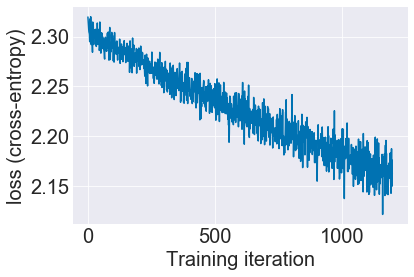

In [9]:
def plot_cross_entropy_loss(loss_history):
    plt.plot(loss_history)
    plt.xlabel('Training iteration')
    plt.ylabel('loss (cross-entropy)')
    plt.show()
    
plot_cross_entropy_loss(loss_history)

### 2d. Questions

**Question 1.** What do you think the linear drop in loss over the epochs tells us about the state of the training process? How is current training going? What's the future potential like?



**Question 2.** Below, write code to test regularization with training: check to make sure that the loss starts at around 154-158 for `reg=100`. Once you get this working, play around with the regularization parameter. You can drastically change the magnitude, but it should always remain nonnegative. How does regularization affect the training loss and **why**?

**Question 3.** Play around with the batch size parameter. How does this affect the training loss and **why**? (*Think about the error gradient and how the weights change*)

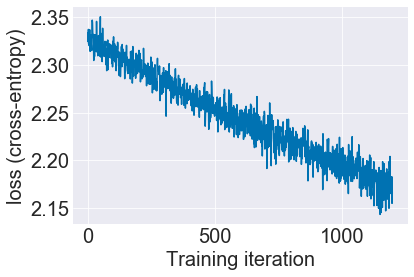

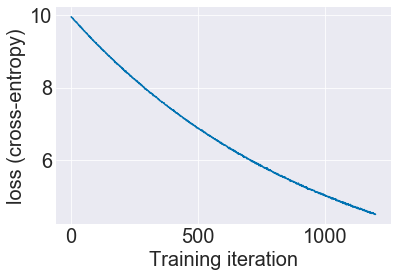

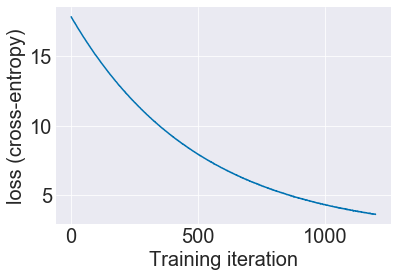

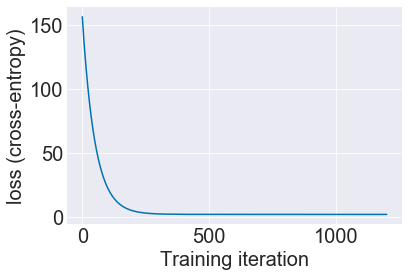

In [10]:
#Question 2: Test regularization with training
reg_val = 0
softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev, n_epochs=600, mini_batch_sz=250, reg = reg_val)
plot_cross_entropy_loss(loss_history)


reg_val = 5
softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev, n_epochs=600, mini_batch_sz=250, reg = reg_val)
plot_cross_entropy_loss(loss_history)

reg_val = 10
softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev, n_epochs=600, mini_batch_sz=250, reg = reg_val)
plot_cross_entropy_loss(loss_history)

reg_val = 100
softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev, n_epochs=600, mini_batch_sz=250, reg = reg_val)
plot_cross_entropy_loss(loss_history)

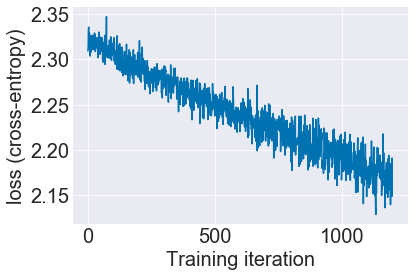

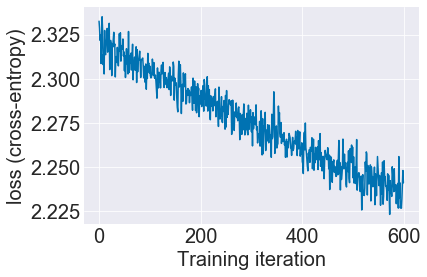

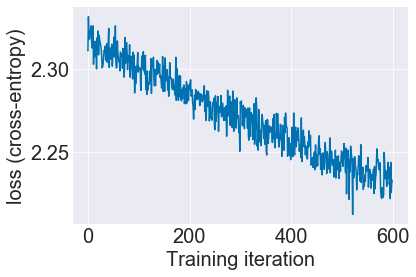

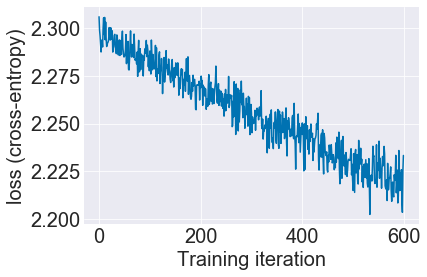

In [11]:
#Question 3: Test batch size with training
size = 200
softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev, n_epochs=600, mini_batch_sz=size)
# y_pred = softmaxNet.predict(x_dev)
# print(softmaxNet.accuracy(y_dev, y_pred))
plot_cross_entropy_loss(loss_history)

size = 300
softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev, n_epochs=600, mini_batch_sz=size)
plot_cross_entropy_loss(loss_history)

size = 400
softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev, n_epochs=600, mini_batch_sz=size)
plot_cross_entropy_loss(loss_history)

size = 500
softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev, n_epochs=600, mini_batch_sz=size)
plot_cross_entropy_loss(loss_history)

**Answer 1:** The linear drop suggests that the training process is at a good state in which the loss decreases. Our network is improving its performance. In the future, the curve might reaches to a plateau which might be even more ideal, suggesting that the network is trained to generate the least amount of loss. The loss curve might also remain flat, suggesting that our network is overfitting the data.

**Answer 2:** When the regularization parameter is large, the loss curve becomes smooth. When the regularization becomes larger, the loss curves decrease more dramatically. Meanwhile, the initial loss gets larger when the regularization parameter is larger. When the regulazation parameter is larger, it penalizes the loss and weights more in each epoch. The loss becomes higher than it should. Therefore, the loss curve starts at higher value when regularization parameter is large.

**Answer 3:** When the batch size increases, the loss slightly decreases. When the batch size is large, the network is able to be trained based on a wider range of data in each iteration. It can prevent our network from getting "stuck" in part of the loss surface due to training sample order effect.

### 2e. Train and optimize STL-10 dataset performance

As you've surely noticed, hyperparameters can drastically affect learning! 


Implement a grid search for the best hyperparameters

- learning rate,
- regularization
- batch size 

The grid search process should:

1. Fit the model with specific values of hyperparameters that we're testing (using the training set).
2. Compute the accuracy on the training set. 
3. Compute the accuracy on the validation set. 
4. Print out and record the best parameter combination as you go (that improves the **validation set accuracy**).
5. Wipe the weights clean (reinitialize them) every time you try new parameters. It's easiest just to create a new net object on each run.

#### Suggestions

This can take quite a bit of simulation time! Here are some tips:
- I suggest using a coarse-to-fine search strategy. First try varying parameters over many orders of magnitude. Use the "new best" print outs to refine the ranges that you test. Abort simulations prematurely if you feel there aren't productive (no reason to wait!). This can take however long or short that you want to dedicate. Remember, you are printing out the best parameter values on each run, so you can just proceed with those.
- You should be able to achieve ~30% accuracy without too much effort (10% is chance performance).
- High learning rates don't really make sense. You'll know if your value is "high" if numpy complains about numerical issues.
- Your mini-batch sizes should be <= N and >= 1.
- Time single network runs with a few different batch sizes you plan on trying in your big search. This will help you figure out a ballpark estimate how long grid search will take (*you can decide whether to go eat dinner, run it overnight, etc.*). If it will take an unreasonable amount of time, reduce the number of parameters you try in one search.

**Important note:** Like usual, I am not grading based on your performance numbers or the number of hours your computer spends searching. I want to see that you successfully implemented the grid search to find progressively better hyperparameters on STL-10 and use the outcome to inform your ultimate training session that you use to evaluate predictions on the test set.

In [12]:
lr_lower = 0.0001
lr_upper = 0.001
lr_step = 0.0002
reg_lower = 0
reg_upper = 100
reg_step = 30
size_lower = 100
size_upper = 500
size_step = 100
acc_val = 0 # set to a big value to overwrite


lr_start = lr_lower
while (lr_start <= lr_upper):
    reg_start = reg_lower
    while reg_start <= reg_upper:
        # print(reg_start)
        size_start = size_lower
        while size_start <= size_upper:
            prev_acc = acc_val
            sm = SoftmaxLayer(10)
            loss_hist = sm.fit(x_dev, y_dev, lr=lr_lower, mini_batch_sz=size_lower, reg=reg_lower, n_epochs=100)
            # acc of training set
            y_train_pred = sm.predict(x_dev)
            print("x_dev shape: ", x_dev.shape)
            print("y_pred shape: ", y_train_pred.shape)
            acc_train = sm.accuracy(y_dev, y_train_pred)
            # print(acc_train)

            # acc of validation set
            y_val_pred = sm.predict(x_val)
            acc_val = sm.accuracy(y_val, y_val_pred)
            
            # print out the combinations if acc_val is improving
            if acc_val > prev_acc:  
                print(f'learning rate: {lr_start}\nregularization: {reg_start}\nbatch size: {size_start}\n  current accuracy: {round(acc_val,5)}\n------------------\n')
            size_start += size_step
        reg_start += reg_step
    lr_start += lr_step

x_dev shape:  (500, 3072)
y_pred shape:  (3072,)
x_dev shape:  (500, 3072)
y_pred shape:  (3072,)
x_dev shape:  (500, 3072)
y_pred shape:  (3072,)
x_dev shape:  (500, 3072)
y_pred shape:  (3072,)
x_dev shape:  (500, 3072)
y_pred shape:  (3072,)
x_dev shape:  (500, 3072)
y_pred shape:  (3072,)
x_dev shape:  (500, 3072)
y_pred shape:  (3072,)
x_dev shape:  (500, 3072)
y_pred shape:  (3072,)
x_dev shape:  (500, 3072)
y_pred shape:  (3072,)
x_dev shape:  (500, 3072)
y_pred shape:  (3072,)
x_dev shape:  (500, 3072)
y_pred shape:  (3072,)


KeyboardInterrupt: 

### 2f. Evaluate best model on test set

**Question 4:** Now that you have "good" parameter values recorded, train a new model with the best learning rate, regularization strength, and batch size values. What accuracy do you get on the test set?

**Answer 4:**

### 2g. Visualize learned weights

Run the following code that plots the network weights going to each output neuron. If all goes well, you should see something really cool! Include the plot in your submitted project to show me what you got!

**Note:** the quality of your visualizations will depend on:
- The quality of the hyperparameters that you got via grid search.
- How many epochs that you trained the network before plotting the weights

One extension idea: is to find the combination of the above that result in the best visualizations.

In [10]:
# Load in the class names
classes = np.loadtxt(os.path.join('data', 'stl10_binary', 'class_names.txt'), dtype=str)

# We don't care about the bias wt
wts = bestNet.wts
# Reshape the wt vectors into spatial 'image' configurations to visualization
wts = wts.reshape(32, 32, 3, 10)

# Make a large new empty figure/plot
plt.figure(figsize=(10, 4))

# Loop through each output neuron
for i in range(10):
  # Make a 2x5 grid of images
  plt.subplot(2, 5, i+1)
  
  # Rescale the weights to be between 0 and 255
  currImg = 255.0 * (wts[:, :, :, i].squeeze() - np.min(wts)) / (np.max(wts) - np.min(wts))
  
  plt.imshow(currImg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

NameError: name 'bestNet' is not defined